# Is humanity's gluttony killing the planet?

With rising life expectancies and a rapid increase in population across the globe, it is getting harder for humanity to sustain its nutritional needs. The inefficient upscale of food production is having a noticeable negative impact on the planet. Deforestation, increased livestock farming, and the excessive use of fertilisers, which are all related to food production, are the main causal factors behind rising emissions in greenhouse gasses and consequently, global warming. In an effort to further the advancements in battling climate change, we aim to reveal how food production and its necessary resources have evolved, and the relation to global warming. We will do so by carrying out an analysis of the data published by the Food and Agriculture Organization of the United Nations (FAOSTAT). We believe that by doing so, we could potentially increase general public awareness of this topic and compel people to keep the stated issue in mind when acting as consumers.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image
from IPython.core.display import SVG
import matplotlib.pyplot as plt
import folium
from matplotlib.ticker import MaxNLocator

- How has the world recenlty evolved in terms of factors that are relevant to agriculture and climate change (agricultural activity, CO2 emissions, deforestation, etc.) ? 
- What are the most popular food types (per country and overall) and their relative impact on CO2 emissions ?
- What countries are the most/least efficient in terms of meeting their nutritional needs ?
- How do countries collaborate in order to meet these needs ?
- Are there any trends in the production of different food types ?
- What realizable good practices exist in order to reduce the negative impacts of food production ?

### How has the world recenlty evolved in terms of factors that are relevant to agriculture and climate change?

As an introductory section to this topic, we will explore how various factors that are related to climate change have evolved in recent years and how humanity's agricultural activity contributes to these. Specifically, we look at:
- Popultion levels
- Temperature evolution
- Greenhouse gas emissions
- Evolution of forest areas

#### Population

First of all, we load the [population dataset](http://www.fao.org/faostat/en/#data/OA) which illustrates the population levels for countries, continents, groups of countries, and the world over time for various population groups (e.g. Males, Females, Both sexes). We particularly look at the evolution of total world population over time and the proportion of world population that is represented by [Low Income Food Deficit Countries (LIFDCs)](http://www.fao.org/countryprofiles/lifdc/en/). LIDFCs are countries that have a per capita Gross National Income (GNI) below a predefined threhsold and that are net food importers in terms of calories. These are of particular interest as these countries are dependent on other countries' food production and thus increases these driving up other nation's CO2 emissions. Additionally, these countries would cause an increase in general flow of food products between countries which drives up emissions caused by transportation.

In [2]:
# Load population data
population_df = pd.read_csv('data/Population_E_All_Data_(Normalized).zip', encoding='latin-1')

In [3]:
# Create dataframe with world level population keeping relevant columns
world_population = population_df[population_df.Area=='World'][['Area', 'Year', 'Element', 'Unit', 'Value']]

# Create dataframe with low income food deficit countries population levels
food_deficit_population = population_df[population_df.Area=='Low Income Food Deficit Countries']\
[['Year', 'Element', 'Value']]

In [4]:
# Rename columns
food_deficit_population = food_deficit_population.rename(columns={'Value': 'num_people_def_countries'})

In [5]:
# Join world population dataset with low income food deficit countries population dataset on Year
world_population = pd.merge(world_population, food_deficit_population, on=['Year', 'Element'], how='inner')

In [6]:
# Compute the proportion of low income food deficit countries' populations of world population for each year
world_population['ratio_def_pop'] = world_population.num_people_def_countries/world_population.Value

In [7]:
# Limit dataset timeline up to 2017 to exclude predictive data
world_population = world_population[(world_population.Year<2018) 
                                    & (world_population.Element=='Total Population - Both sexes')]

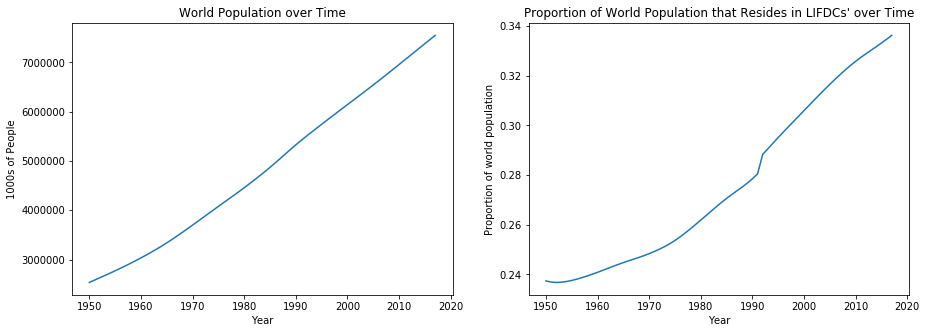

In [8]:
# Plot evolution of world population and proportion of both aforementioned sub groups over time
fig = plt.figure(figsize=(15,5))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.plot(world_population.Year.values, world_population.Value.values)
p1.set_title('World Population over Time')
p1.set_xlabel('Year')
p1.set_ylabel('1000s of People')
p2.plot(world_population.Year.values, world_population.ratio_def_pop.values)#, label='Low Income Food Deficit Countries')
p2.set_title("Proportion of World Population that Resides in LIFDCs' over Time")
p2.set_xlabel('Year')
p2.set_ylabel('Proportion of world population')
plt.show()

We can clearly observe that the overall population level of the planet has significantly increased over the past 60 years (going roughly from 2.5 to 7.5 billion). Alongside this, we notice that the proportion of the total population that reside in countries that are LIDFCs is also on the rise. This highlights the fact that there is a greater number of humans that rely on limited food production resources. Both, world and LDIFC population growths are striking and signal upcoming challenges in the ability to sustain these in an efficient manner in terms of green house gas emissions.

While processing the data above, we noticed that different levels of aggregation (countries, continents, etc.) are represented as separate rows. In order to obtain the mapping between continents and countries, which will be useful throughout our analysis, we downloaded this information from the FAOSTAT website (as it was not available in the original datasets) and integrated it with the populations data.

In [9]:
# Load country metadata mapping country groups to countries
country_metadata = pd.read_csv('data/FAOSTAT_data_11-19-2019.csv')

In [10]:
# Extract list of countries and continents from the above dataset
countries = country_metadata.Country.drop_duplicates().values
continents = country_metadata[(country_metadata['Country Group Code']>5000) & (country_metadata['Country Group Code']%100==0)]
continents = continents['Country Group'].drop_duplicates().values

In [11]:
# Create dataframe for total country populations
#country_populations = population_df[(population_df.Area.isin(countries)) 
#                                    & (population_df.Element=='Total Population - Both sexes')].copy()
#country_populations['Population'] = country_populations.Value * 1000
#country_populations = country_populations[['Area', 'Year', 'Population']]

In [12]:
# Extract country group to country mapping from new dataset
#country_to_group = country_metadata[['Country Group', 'Country']]

In [13]:
# Join total country populations dataframe to country group to country mapping
#new_population_df = pd.merge(country_populations, country_to_group, 
#                            left_on='Area', right_on='Country')
#new_population_df = new_population_df[['Year', 'Country Group', 'Country', 'Population']]
#new_population_df.head()

#### Evolution of temperature levels

Secondly, we investigate how the temperature levels have evolved in recent years. We visualise the evolution of the world's yearly temperature anomlies. Temperature anomalies, as defined in [FAOSTAT documentation](http://fenixservices.fao.org/faostat/static/documents/ET/ET_e.pdf), indicate how much warmer or colder it is than normal for a particular place and time. Normal always means the average over the 30-year period 1951-1980 for that place and time of year. 

In [14]:
# Load temperatures dataset
temperatures_df = pd.read_csv('data/Environment_Temperature_change_E_All_Data_(Normalized).zip', encoding='latin-1')

In [15]:
# Create dataframe retaining information pertaining to the world, yearly averages and temperature changes
world_temperatures_changes = temperatures_df[(temperatures_df.Area=='World') 
                                             & (temperatures_df.Months=='Meteorological year') 
                                             & (temperatures_df.Element=='Temperature change') ]

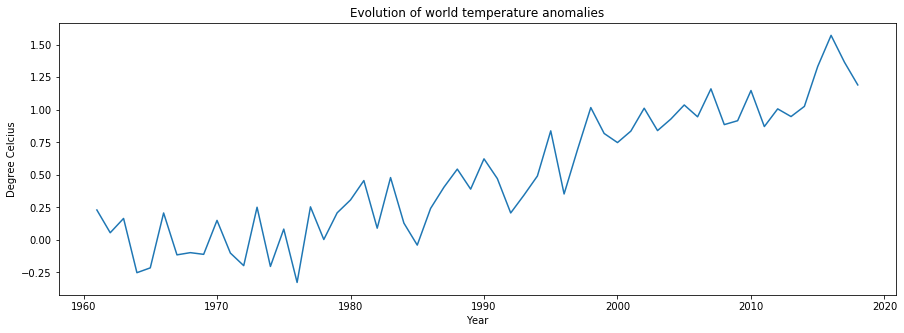

In [16]:
# Plot the evolution of world temperature anomalies
plt.figure(figsize=(15,5))
plt.plot(world_temperatures_changes.Year.values, world_temperatures_changes.Value.values)
plt.title('Evolution of world temperature anomalies')
plt.xlabel('Year')
plt.ylabel('Degree Celcius')
plt.show()

From the above plot, the increasing trend in temperature is apparent even though we have only plotted data since 1960 (all that is available from FAOSTAT). If data prior to 1960 was made available, we would most likely have seen a longer ranging increasing trend since rising temperatures relate to greenhouse gas emissions which have started to increase since the industrial revolution. As rising temperature relate to greenhouse gas emissions, we investigate these next.

#### Greenhouse Gas Emissions

Now we investigate the evolution of the CO2 equivalent emissions coming from Agriculture across the world. We also look at the contribution of these emissions to the total CO2 equivalent emissions. Greenhouse gas emissions in Agriculture consist of non-CO2 gases, namely methane (CH4) and nitrous oxide (N2O), associated with crop and livestock production and associated management activities. These are converted into CO2 equivalent emissions according to their global warming potential as outlined in [FAOSTAT documentation](http://fenixservices.fao.org/faostat/static/documents/GT/GT_e_2019.pdf).

In [17]:
# Load emissions by sector dataset
emissions_by_sector_df = pd.read_csv('data/Environment_Emissions_by_Sector_E_All_Data_(Normalized).zip', 
                                  encoding='latin-1')

# Load agriculture emissions dataset
agriculture_emissions_df = pd.read_csv('data/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).zip', 
                                       encoding='latin-1')

In [18]:
# Extract into a dataframe the latest data for different sectors' share in total global emissions
emissions_world_sectors = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                & (emissions_by_sector_df.Area=='World')
                                                & (emissions_by_sector_df.Year==emissions_by_sector_df.Year.max())]

The list of sectors below represents all the disjoint sectors that make up the total and was taken from [FAOSTAT official documentation](http://fenixservices.fao.org/faostat/static/documents/EM/EM_e.pdf)

In [19]:
sectors = ['Energy (energy, manufacturing and construction industries and fugitive emissions)', 'Transport', 
           'Residential, commercial, institutional and AFF', 'Industrial processes and product use', 'Waste', 
           'Other sources', 'International bunkers', 'Agriculture total', 'Land use sources']

In [20]:
# Filter emissions by sector dataframe to the above list of sectors
pie_df = emissions_world_sectors[emissions_world_sectors.Item.isin(sectors)]

In [21]:
# Extract into a dataframe the historic values of agriculture's share in total world emissions
world_ag_emissions_hist = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                 & (emissions_by_sector_df.Area=='World')
                                                 & (emissions_by_sector_df.Item=='Agriculture total')]

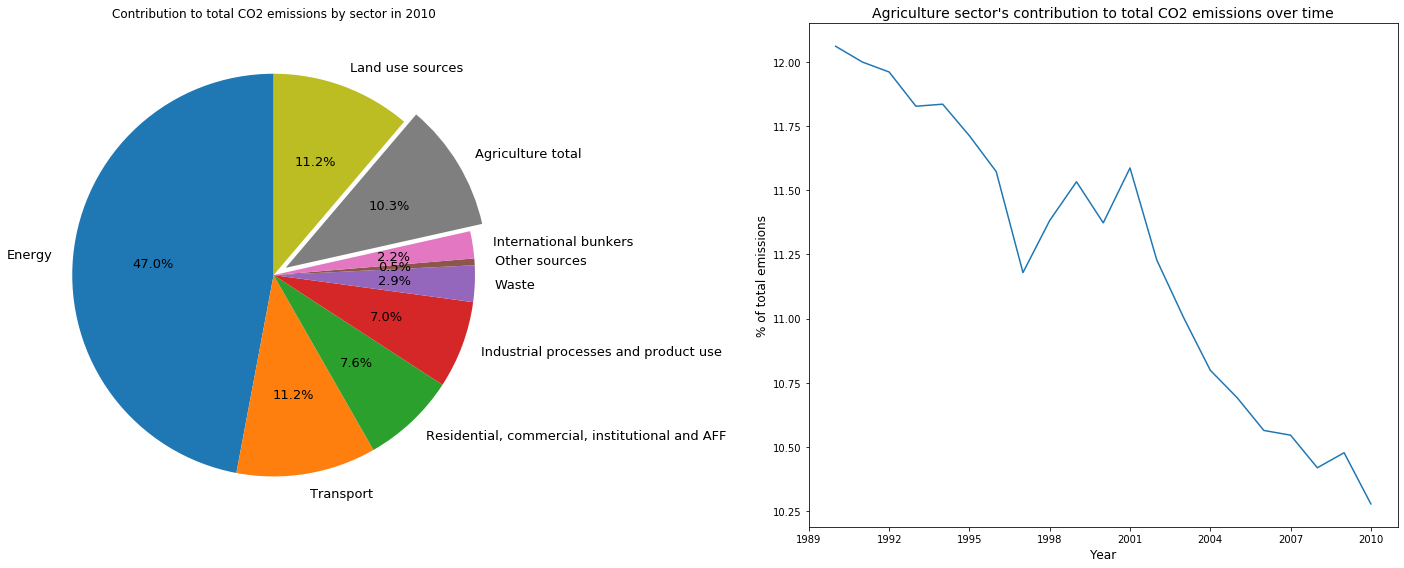

In [22]:
# Plot latest sector contributions to global emissions and the historic evolution of agriculture's share
fig = plt.figure(figsize=(20,8))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
sector_labels = sectors.copy()
sector_labels[0] = 'Energy'
p1.pie(pie_df.Value.values, explode=[0,0,0,0,0,0,0,0.07,0], labels=sector_labels, autopct='%1.1f%%', startangle=90, 
       textprops={'fontsize': 13})
p1.set_title('Contribution to total CO2 emissions by sector in ' + str(pie_df.Year.max()), fontsize=12)
p2.plot(world_ag_emissions_hist.Year.values, world_ag_emissions_hist.Value.values)
p2.set_xlabel('Year', fontsize=12)
p2.set_ylabel('% of total emissions', fontsize=12)
p2.xaxis.set_major_locator(MaxNLocator(integer=True))
p2.set_title("Agriculture sector's contribution to total CO2 emissions over time", fontsize=14)
plt.tight_layout(w_pad=1)
plt.show()

From the pie plot above we can see that agriculture represents a sizeable proportion of total CO2 emissions (about 10%). It is worth noting that since agricultural products are imported and exported across the globe, Agriculture also impacts the emissions emanating from the Transport sector. Note that the biggest proportion of emissions comes from energy (energy, manufacturing and construction industries and fugitive emissions). Although we see that agriculture's share of emissions has decresead over the years (roughly from 12% to 10%), this could be potentially caused by the increase of another sector's share. We explore the evolution of the actual emissions from the agricultural sector below.

In [23]:
# Extract into a dataframe nominal values of agriculture CO2, CO2eq of CH4 and CO2eq of N2O emissions
world_agriculture_emissions = agriculture_emissions_df[(agriculture_emissions_df.Area=='World') 
                                                       & ~(agriculture_emissions_df.Element.isin(['Emissions (CH4)', 'Emissions (N2O)']))
                                                       & (agriculture_emissions_df.Item=='Agriculture total')
                                                       & (agriculture_emissions_df.Year<2018)]

In [24]:
# Extract list of years and gas types for plot below
xticks = world_agriculture_emissions.Year.drop_duplicates().sort_values().values
labels = world_agriculture_emissions.Element.drop_duplicates().values

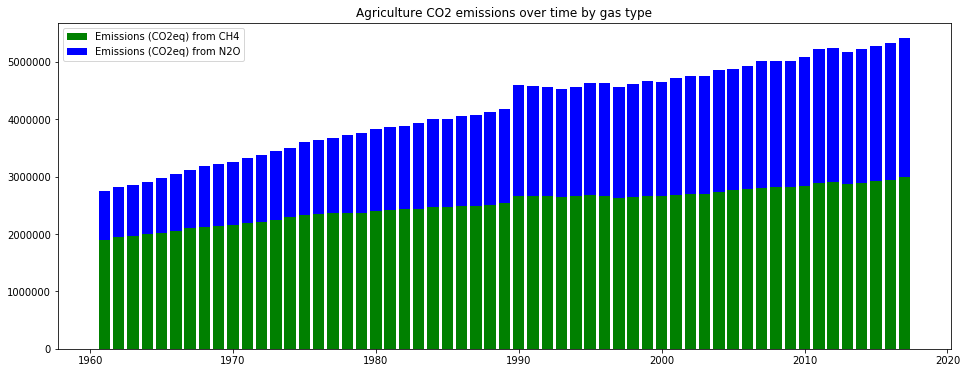

In [25]:
# Plot world's CO2eq emissions of agriculture sector over time split by CO2eq of CH4 and CO2eq of N2O
plt.figure(figsize=(16,6))
p1 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[1]].Value.values, 
             color='g', label=labels[1])
p2 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[2]].Value.values, 
             bottom=world_agriculture_emissions[world_agriculture_emissions.Element==labels[1]].Value.values, 
             color='b', label=labels[2])
plt.title('Agriculture CO2 emissions over time by gas type')
plt.legend()
plt.show()

From the plot above we see that there is actually a steady increase in CO2 emissions emanating from the agricultural sector. This confirms the previously stated assumptions that although the agricultural sector's share of CO2 emissions has decreased, the actual value of emissions has increased. Additionally, we notice that in 1990 there is a slight abnormal jump in the level of CO2 emissions. Investigating the [FAOSTAT documentation](http://fenixservices.fao.org/faostat/static/documents/GT/GT_e_2019.pdf) related to this dataset, we learned that data for two types of emissions, namely 'Cultivation of organic soils' and 'Burning–savanna', start in 1990 which explains this jump. As such, to have a more illustrative view of the trend in CO2 emissions since 1960 we remove the emission data related to these two items from the dataset and replot.

In [26]:
# Compute total world CO2eq emissions from Cultivation of organic soils and Burning-savanna since 1990
new_emissions = ['Cultivation of Organic Soils', 'Burning - Savanna']
new_emissions_df = agriculture_emissions_df[(agriculture_emissions_df.Item.isin(new_emissions))
                                            & (agriculture_emissions_df.Area=='World')
                                            & (agriculture_emissions_df.Element=='Emissions (CO2eq)')]
new_emissions_df = new_emissions_df[['Year', 'Value']].groupby('Year').agg('sum')

Additionally, we also compute and plot the CO2eq emissions from Agriculture per capita over time. This would allow us to observe how increase in world population that we have observed earlier compares to the above increase in agricultural CO2eq emissions.

In [27]:
# Update previously computed world population dataframe to include population in number of people rather than in 1000s
population_hist = world_population[['Year', 'Value']].copy()
population_hist['Population'] = 1000 * population_hist.Value

In [28]:
# Join world agricultural emissions dataframe to population dataframe on year to have both on joint timeline
agriculture_co2_emissions = pd.merge(population_hist[['Year', 'Population']], 
                                     world_agriculture_emissions[world_agriculture_emissions.Element==labels[0]],
                                     on='Year')

agriculture_co2_emissions = agriculture_co2_emissions[['Year', 'Population', 'Area', 'Element', 'Unit', 'Value']]

In [29]:
# Join in data relating to new emissions starting in 1990 computed above
agriculture_co2_emissions = pd.merge(agriculture_co2_emissions, new_emissions_df, 
                                     on='Year', how='left', suffixes=('', '_new')).copy()

In [30]:
# For years prior to 1990 set new emissions value to 0
agriculture_co2_emissions.loc[agriculture_co2_emissions.Value_new.isnull(), 'Value_new'] = 0

# Compute total world agricultural CO2eq emissions for each year excluding the new emissions starting in 1990
agriculture_co2_emissions['Value'] = agriculture_co2_emissions.Value - agriculture_co2_emissions.Value_new

In [31]:
# Compute CO2eq emissions per capita
agriculture_co2_emissions['ag_co2_pc'] = agriculture_co2_emissions.Value / agriculture_co2_emissions.Population

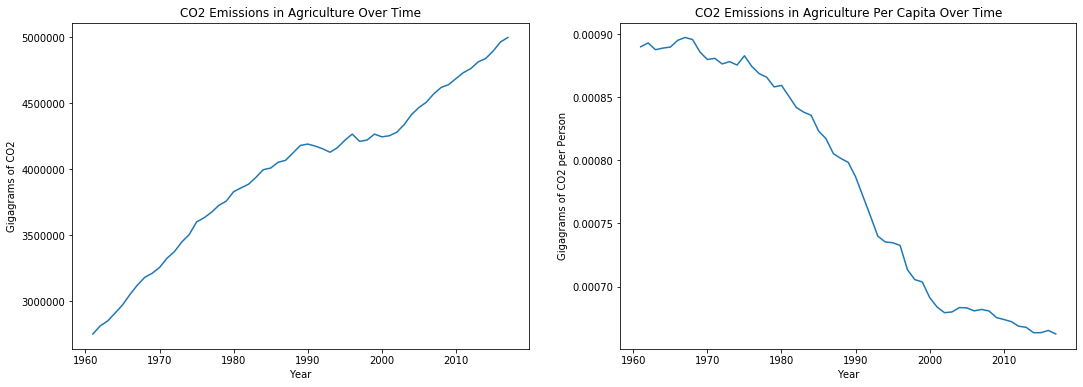

In [32]:
# Plot nominal and per capita CO2eq world agricultural emissions over time excluding new emissions
fig = plt.figure(figsize=(18,6))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.plot(agriculture_co2_emissions.Year.values, agriculture_co2_emissions.Value.values)
p2.plot(agriculture_co2_emissions.Year.values, agriculture_co2_emissions.ag_co2_pc.values)
p1.set_xlabel('Year')
p1.set_ylabel('Gigagrams of CO2')
p1.set_title('CO2 Emissions in Agriculture Over Time')
p2.set_xlabel('Year')
p2.set_ylabel('Gigagrams of CO2 per Person')
p2.set_title('CO2 Emissions in Agriculture Per Capita Over Time')
plt.show()

Having removed the effect of the additional emissions caused by 'Cultivation of organic soils' and 'Burning–savanna', we can now observe a smoother increase in agricultural CO2 emissions over time. Additionally, we also plot the number of gigagrams of agricultural CO2 emissions normalized by the world population as a function of time. We can observe that this curve decreases over time, as opposed to the one relating to the emissions of CO2. We have already observed that the world population has significantly increased over the same time period. This means that the increase in world population is greater than the increase in agricultural CO2 emissions. Since it is safe to assume that the vast majority of the world relies on agriculture for their nutritional needs, this could illustrate the fact that, in terms of efficiency of agricultural activity relative to CO2 emissions, the world has made progress over the last half century. This ties in well with the fact that the world has also made signifcant technological progress over the same time period. We investigate this further later on. Nonetheless, as our initial plot demonstrates, the CO2 levels are rising. A counter balancing factor to CO2 emissions are the carbon-absorbing properties of plants and trees. As such, we investigate the evolution of the world's forest areas below.

#### Forest Area

As outlined above, plants and trees having carbon-absorbing properties. As a result, they represent a major factor in balancing the CO2 levels of the planet. Therefore, we investigate how the forest area of the planet have evolved over time.

In [33]:
# Load the land area dataset
land_df = pd.read_csv('data/fao_data_land_data.zip', encoding='latin-1')

In [34]:
# Display the year of the most recent data point of interest
land_df[(land_df.country_or_area=='World +') & (land_df.category=='forest_area')].year.max()

2007.0

As the above land data only goes up to 2007, as opposed to the visualised datasets so far which go up to 2017, we decided to download the data from [FOASTAT](http://www.fao.org/faostat/en/#data/RL) instead.

In [35]:
# Load the newer version of the land area dataset
land_df = pd.read_csv('data/Inputs_LandUse_E_All_Data_(Normalized).zip', encoding='latin-1')

In [36]:
# Display the year of the most recent data point of interest
land_df[(land_df.Area=='World') & (land_df.Item=='Forest land')].Year.max()

2017

In [37]:
# Extract latest country area data for each country
land_per_country = land_df[(land_df.Area.isin(countries)) & (land_df.Element=='Area') 
                           & (land_df.Item=='Country area') & (land_df.Year==land_df.Year.max())]

# Extract latest forest area data for each country
forest_per_country = land_df[(land_df.Area.isin(countries)) & (land_df.Element=='Area') 
                             & (land_df.Item=='Forest land')]

fpc_latest = forest_per_country[forest_per_country.Year==forest_per_country.Year.max()]

In [38]:
# Join forest area and country area data on year and country
fpc_latest = pd.merge(fpc_latest, land_per_country[['Area', 'Year', 'Value']], 
                              on=['Year', 'Area'], how='left')

# Keep desired columns and rename appropriately
fpc_latest = fpc_latest[['Area Code', 'Area', 'Unit', 'Value_x', 'Value_y']]
fpc_latest = fpc_latest.rename(columns=({'Value_x': 'forest_area', 'Value_y': 'land_area'}))

We noticed that South Sudan and Sudan do not have any data for their respective country areas although the forest land area appears as shown below.

In [39]:
land_df[(land_df.Area.str.contains('Sudan')) & (land_df.Year==land_df.Year.max()) & (land_df.Element=='Area')
       & (land_df.Item.isin(['Country Area', 'Forest land']))]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
140588,277,South Sudan,6646,Forest land,5110,Area,2017,2017,1000 ha,7157.000,Fm
142352,276,Sudan,6646,Forest land,5110,Area,2017,2017,1000 ha,19209.938,Fm


As a result, we added the country area of [Sudan](https://en.wikipedia.org/wiki/Sudan) and [South Sudan](https://en.wikipedia.org/wiki/South_Sudan) in 1000s of Ha (found on wikipedia) in the dataframe below.

In [40]:
fpc_latest.loc[fpc_latest['Area']=='South Sudan', 'land_area'] = 61974.5
fpc_latest.loc[fpc_latest['Area']=='Sudan', 'land_area'] = 188606.8 

In [41]:
# Compute proportion of forest land compared to total area for each country
fpc_latest['forest_proportion'] = fpc_latest.forest_area / fpc_latest.land_area

In [42]:
# Add country codes for each country in order to plot map in Folium
country_to_code = country_metadata[['Country Code', 'ISO3 Code']].drop_duplicates().set_index('Country Code')
fpc_latest = pd.merge(fpc_latest, country_to_code, left_on='Area Code', right_index=True, how='left')

In [43]:
# We noticed that the country code of South Sudan did not correspond to the code expected by folium so we update it
fpc_latest.loc[fpc_latest['Area']=='South Sudan', 'ISO3 Code'] = 'SDS'

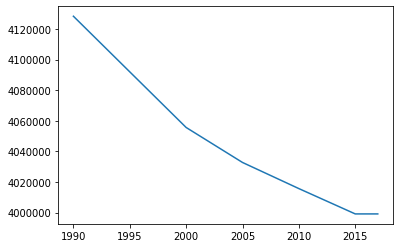

In [44]:
plt.plot(land_df[(land_df.Item=='Forest land') & (land_df.Area=='World') & (land_df.Element=='Area')].Year.values,
         land_df[(land_df.Item=='Forest land') & (land_df.Area=='World') & (land_df.Element=='Area')].Value.values)
plt.show()

In [45]:
top10_forest_2017 = fpc_latest[['Area', 'forest_area']].groupby(['Area'], as_index=False)\
                .agg('mean').sort_values('forest_area', ascending=False).reset_index(drop=True).head(10)

top10_forest_1992 = forest_per_country[(forest_per_country.Area.isin(top10_forest_2017.Area.values)) 
                                & (forest_per_country.Year==1992)][['Area', 'Value']].reset_index(drop=True)\
                            .sort_values('Value', ascending=False)

In [46]:
top10_forest_hist = pd.merge(top10_forest_1992, top10_forest_2017, on='Area')
top10_forest_hist = top10_forest_hist.rename(columns=({'Value': 'forest_area_92', 'forest_area': 'forest_area_17'}))
top10_forest_hist['change'] = top10_forest_hist.forest_area_17 / top10_forest_hist.forest_area_92

In [47]:
world_map = 'data/world_countries.json'
forest_map = folium.Map(location=[40, 15], zoom_start=2)

In [48]:
folium.Choropleth(
    geo_data=world_map,
    data=fpc_latest,
    columns=['ISO3 Code', 'forest_proportion'],
    key_on='feature.id',
    fill_color='YlGn', 
    fill_opacity=0.9, 
    line_opacity=0.2,
    nan_fill_color='grey',
    legend_name='Proportion of Country Area that is Forest Land'
).add_to(forest_map)
forest_map

In [49]:
#populations_df = pd.read_csv('data/Population_E_All_Data_(Normalized).zip', encoding='latin-1')
# print(populations_df.Element.unique())
# print(populations_df.Item.unique())
population_df['is_country'] = population_df['Area Code'].apply(lambda code: len(str(code)) < 4)
populations_2014 = population_df[(population_df.Element == 'Total Population - Both sexes') & (population_df.is_country)
                               & (population_df.Year == 2014) & (population_df.Area != 'China, mainland')]
populations_2014 = populations_2014[['Area', 'Value']].sort_values(by='Value', ascending=False)
populations_2014 = populations_2014.rename(columns={'Value': 'Population'})

In [94]:
emissions_df = pd.read_csv('data/Environment_Emissions_intensities_E_All_Data_(Normalized).zip', encoding='latin-1')

In [51]:
world_emissions_intensity = emissions_df[(emissions_df.Element == 'Emissions intensity') & (emissions_df.Area == 'World')]
items = world_emissions_intensity.Item.unique().tolist()
meat = list(filter(lambda x: 'Meat' in x, items))
milk = list(filter(lambda x: 'Milk' in x, items))
remaining = list(set(items) - set(meat + milk))

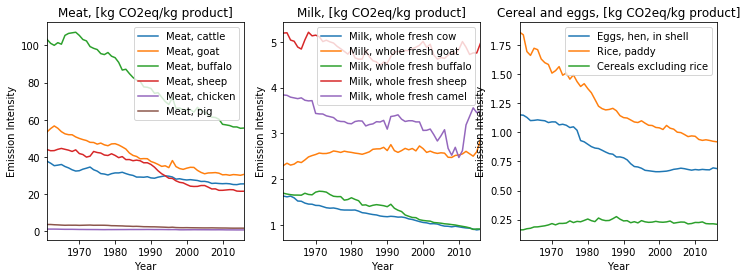

In [52]:
world_emissions_intensity = world_emissions_intensity[['Item', 'Year', 'Value']].groupby(['Item', 'Year'], as_index=False).agg('mean')
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for item in meat:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[0], label=item)
    axes[0].legend()
    axes[0].set_ylabel('Emission Intensity')
    axes[0].set_title('Meat, [kg CO2eq/kg product]')
for item in milk:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[1], label=item)
    axes[1].legend()
    axes[1].set_ylabel('Emission Intensity')
    axes[1].set_title('Milk, [kg CO2eq/kg product]')
for item in remaining:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[2], label=item)
    axes[2].legend()
    axes[2].set_ylabel('Emission Intensity')
    axes[2].set_title('Cereal and eggs, [kg CO2eq/kg product]')

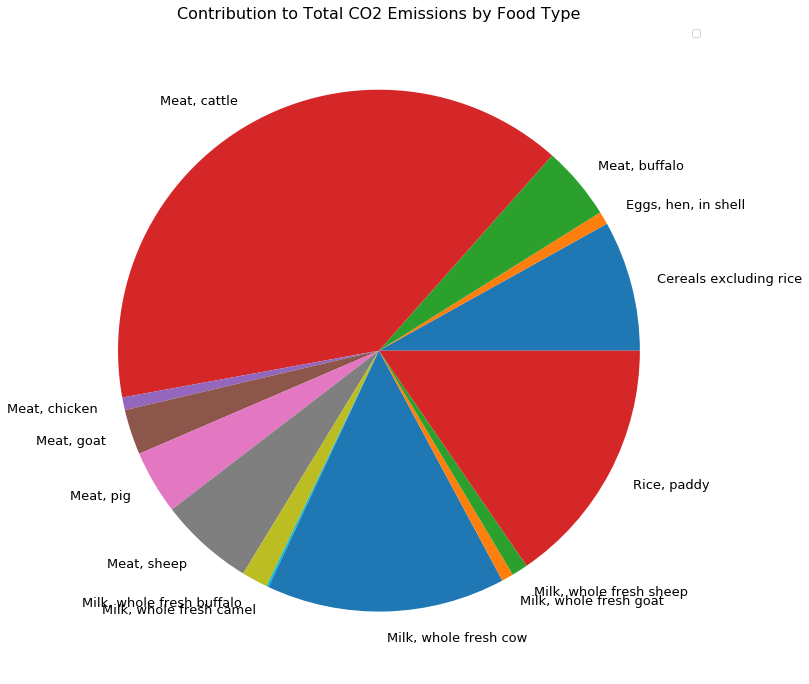

In [53]:
fig, ax = plt.subplots(figsize=(12, 12))
world_net_emissions = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.Area == 'World')]
world_net_emissions[['Item', 'Value']].groupby('Item').agg('sum').plot.pie(y='Value', ax=ax, fontsize=13)
ax.set_ylabel('')
ax.legend('')
ax.set_title('Contribution to Total CO2 Emissions by Food Type', fontsize=16)
plt.show() 

In [54]:
fao_crops_df = pd.read_csv('data/fao_data_crops_data.zip', encoding='latin-1')

In [55]:
fao_fertilizer_df = pd.read_csv('data/fao_data_fertilizers_data.zip', encoding='latin-1')

In [56]:
rice_prod_df = fao_crops_df[(fao_crops_df.category == 'rice_paddy') & (fao_crops_df.element == 'Production Quantity')]
rice_area_df = fao_crops_df[(fao_crops_df.category == 'rice_paddy') & (fao_crops_df.element == 'Area Harvested')]

In [57]:
continents_ = ['Africa +', 'Asia +', 'Americas +', 'Europe +', 'Oceania +']

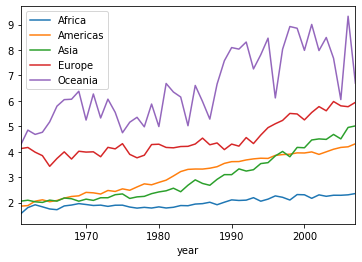

In [58]:
ax = plt.gca()
for continent in continents_:
    efficiency_df = rice_prod_df[rice_prod_df.country_or_area == continent].groupby('year').agg('sum') / \
          rice_area_df[rice_area_df.country_or_area == continent].groupby('year').agg('sum')
    efficiency_df.plot(ax=ax)
    ax.legend(continents)

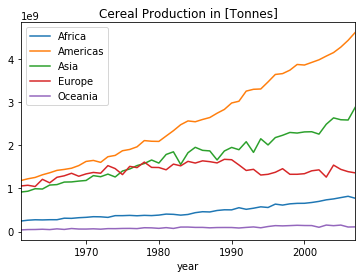

In [59]:
cereal_production_df = fao_crops_df[fao_crops_df.element == 'Production Quantity']
cereal_production_df = cereal_production_df[~cereal_production_df.category.str.contains('total')]
ax = plt.gca()
for continent in continents_:
    cereal_production_df[cereal_production_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Cereal Production in [Tonnes]')

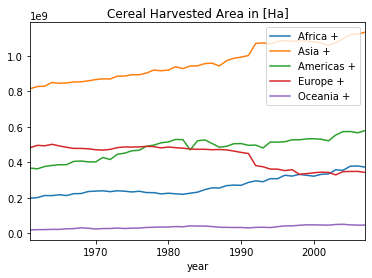

In [60]:
cereal_area_df = fao_crops_df[fao_crops_df.element == 'Area Harvested']
cereal_area_df = cereal_area_df[~cereal_area_df.category.str.contains('total')]
ax = plt.gca()
for continent in continents_:
    cereal_area_df[cereal_area_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents_)
    ax.set_title('Cereal Harvested Area in [Ha]')

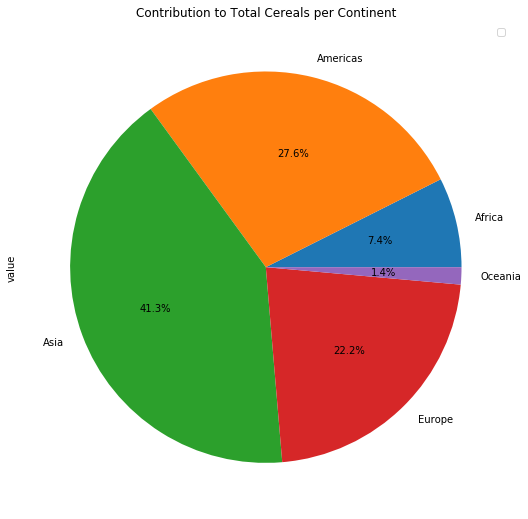

In [61]:
fig, ax = plt.subplots(figsize=(9, 9))
continent_production = cereal_production_df[(cereal_production_df.country_or_area.isin(continents_)) & \
                                      (~cereal_production_df.category.str.contains('total'))]
continent_production[['country_or_area', 'value']].groupby('country_or_area').agg('sum')\
    .plot.pie(y='value', autopct='%1.1f%%', labels=continents, ax=ax)
ax.legend('') 
ax.set_title('Contribution to Total Cereals per Continent')
plt.show()

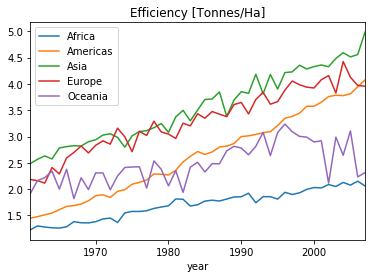

In [62]:
ax = plt.gca()
for continent in continents_:
    efficiency_df = cereal_production_df[cereal_production_df.country_or_area == continent].groupby('year').agg('sum') / \
          cereal_area_df[cereal_area_df.country_or_area == continent].groupby('year').agg('sum')
    efficiency_df.plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Efficiency [Tonnes/Ha]')

In [63]:
food_balance_df = pd.read_csv('data/FoodBalanceSheets_E_All_Data_(Normalized).zip', encoding='latin-1')

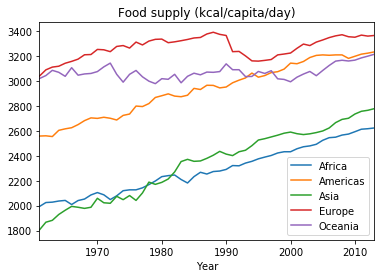

In [64]:
cereals_df = food_balance_df[(food_balance_df.Element == 'Food supply (kcal/capita/day)') & 
                (food_balance_df.Item == 'Grand Total')][['Area', 'Year', 'Value']]
cereals_df
ax = plt.gca()
for continent in continents:
    cereals_df[cereals_df.Area == continent].plot(ax=ax, x='Year', y='Value')
    ax.legend(continents)
    ax.set_title('Food supply (kcal/capita/day)')

# Which countries contribute the most to the greenhouse effect by their agriculture
In this section we'll try to see which countries are the biggest productors in greenhouse gases. To achieve this goal we'll be using the `Emissions intensities` [dataset](http://www.fao.org/faostat/en/#data/EI) which contains inforamtion related to the amount of [carbon dioxide equivalent](https://en.wikipedia.org/wiki/Carbon_dioxide_equivalent), `Emissions (CO2eq)`, generated by an aliment for a given country and year. In the context of this task we'll focusing on the latest available year, which happen to be 2014 for this dataset. As a first order approach each country will be attributed the amount of `Emissions (CO2eq)` that was produced in its own agricultural sector. 

In [65]:
emissions_df = pd.read_csv('data/Environment_Emissions_intensities_E_All_Data_(Normalized).zip', encoding='latin-1')
emissions_df = emissions_df[emissions_df.Area != 'China']
# print(emissions_df.Element.unique())
# print(emissions_df.Item.unique())
# print(emissions_df.Year.max())
# print(emissions_df.Unit.unique())
# emissions_df[emissions_df.Element == 'Emissions (CO2eq)']

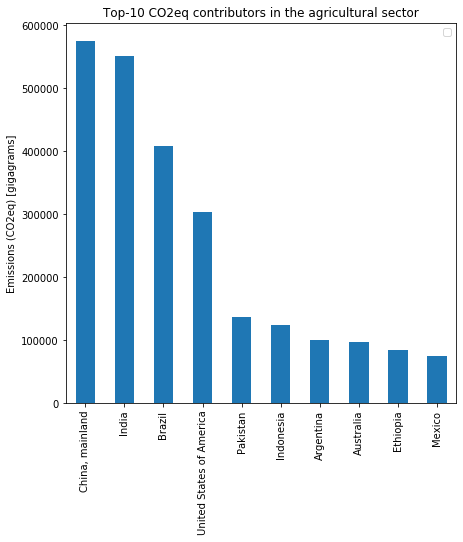

In [66]:
emissions_df['is_country'] = emissions_df['Area Code'].apply(lambda code: len(str(code)) < 4)
emissions_country = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.is_country)]
emissions_country_total = emissions_country[emissions_country.Year == 2014][['Area', 'Value']]\
    .groupby('Area', as_index=False).agg('sum').sort_values(by='Value', ascending=False)

fig, ax = plt.subplots(figsize=(7, 7))
emissions_country_total.rename(columns={'Area': 'Country', 'Value': 'Emissions (CO2eq) [gigagrams]'})\
    .head(10).plot.bar(x='Country', y='Emissions (CO2eq) [gigagrams]', ax=ax)
ax.set_title('Top-10 CO2eq contributors in the agricultural sector')
ax.set_xlabel('')
ax.legend('')
ax.set_ylabel('Emissions (CO2eq) [gigagrams]')
plt.show()

Say something smart. Nonetheless it also appears that the above countries are also the ones with the largest populations. This factor should be taken into account as it clearly is unfair towards big countries. As a more refined analysis we'll normalize the `Emissions (CO2eq)` by each country's population such as to get the `Emissions (CO2eq)/capita`.

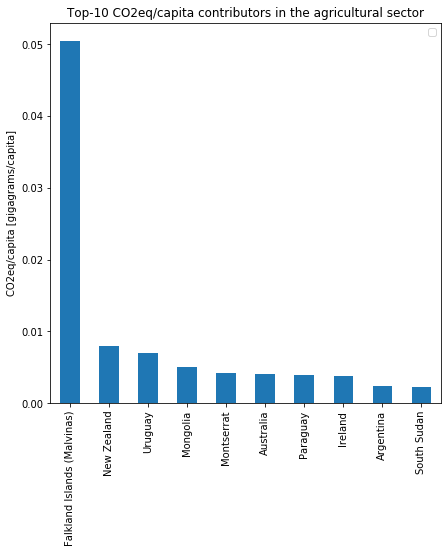

In [67]:
emissions_normalized = emissions_country_total.merge(populations_2014, how='inner')
emissions_normalized['Emissions (CO2eq)/capita'] = emissions_normalized.Value / (1000 * emissions_normalized.Population)

fig, ax = plt.subplots(figsize=(7, 7))
emissions_normalized.sort_values(by='Emissions (CO2eq)/capita', ascending=False)\
    .head(10).plot.bar(x='Area', y='Emissions (CO2eq)/capita', ax=ax)
ax.set_title('Top-10 CO2eq/capita contributors in the agricultural sector')
ax.set_xlabel('')
ax.set_ylabel('CO2eq/capita [gigagrams/capita]')
ax.legend('')
plt.show()

We observe a significant change in the top-10 represented countries as small countries/regions did not appear in the previous plot as their absolut `Emissions (CO2eq)`was not high enough. For the story, `Falkland Islands (Malvinas)` which may appear as an outlier can be explained as it is currently ranked $5^{th}$ in the worldwide GDP per capita and the fishing industry contributes towards 50-60% of its annual GDP ([Falkland Islands](https://en.m.wikipedia.org/wiki/Falkland_Islands)). It might seem artifical to give so much weight to countries whose total contribution is not absolutely high, nevertheless these countries also have the largest improvement margin, at least it appears so. In fact, this method is still intrinsically unfair as it doesn't take into account the amount of food that transits between countries. It is very likely that some of the food produced in ` Falkland Islands (Malvinas)` is then exported to other countries. A natural thing to do is to re-distribute the emissions related to exported food to where the latter will be consummed. To this end we used the `Detailed trade matrix` (dataset)[http://www.fao.org/faostat/en/#data/TM] which contains informations regarding the transfer of food inbetween countries. From the latter dataset only trades corresponding to food for which the emission intensity was available were treated.

The dataset `data/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip` contains a lot of very specific items like `Millet`, `Sorghumand` etc. Thefore, we will only consider overlapping items with the `emissions_df` dataframe. Since cereals are one of the most present items, we will agreggate them into a more general category `Cereals excluding rice` for which we have all the emissions information. Moreover, the column name `Rice - total  (Rice milled equivalent)` is changed into `Rice, paddy`. 1 unit of `Value` represents 1 tonne.


In [68]:
trade_matrix_df = pd.read_csv('data/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip', encoding='latin-1')

In [69]:
# From the FAOSTAT website
cereals = ['Barley',  'Maize',  'Millet',  'Oats', 'Rye', 'Sorghumand', 'Wheat']

def to_cereals(st):
    if st in cereals:
        return 'Cereals excluding rice'
    elif st == 'Rice - total  (Rice milled equivalent)':
        return 'Rice, paddy'
    return st

In [70]:
# Filter as described above
trade_matrix_df.loc[:, 'Item'] = trade_matrix_df.Item.apply(to_cereals)
trade_matrix_df = trade_matrix_df[trade_matrix_df.Item.isin(emissions_df.Item.unique())]
trade_matrix_df = trade_matrix_df[trade_matrix_df['Partner Countries']!='Unspecified Area']
trade_matrix_df = trade_matrix_df[trade_matrix_df['Reporter Countries']!='Unspecified Area']

In [71]:
# Remove useless columns
stripped_trade_matrix_df = trade_matrix_df[['Reporter Countries', 'Partner Countries', 'Value', 'Year', 'Item']]
stripped_trade_matrix_df.Item.unique()

array(['Cereals excluding rice', 'Meat, chicken', 'Meat, sheep',
       'Rice, paddy', 'Milk, whole fresh cow', 'Eggs, hen, in shell',
       'Meat, cattle', 'Meat, pig', 'Meat, goat',
       'Milk, whole fresh sheep'], dtype=object)

In [72]:
# Export quantity per items
stripped_trade_matrix_df = trade_matrix_df[trade_matrix_df.Year==2014]
exports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Export Quantity']
exports_2014 = exports_2014[exports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Item', 'Value']]
exports_2014 = exports_2014.rename(columns={"Reporter Countries": "Exporter", "Partner Countries": "Importer"})
exports_2014 = exports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('sum').reset_index()

In [73]:
# Import quantity per items
imports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Import Quantity']
imports_2014 = imports_2014[imports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Item', 'Value']]
imports_2014 = imports_2014.rename(columns={"Reporter Countries": "Importer", "Partner Countries": "Exporter"})
imports_2014 = imports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('sum').reset_index()

In [74]:
# All quantity per items
merged_exports_2014 = pd.concat([imports_2014, exports_2014])
merged_exports_2014 = merged_exports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('max').reset_index()
merged_exports_2014 = merged_exports_2014.sort_values(['Value'], ascending=[False])
merged_exports_2014.head(10)

,Exporter,Importer,Item,Value
15766,United States of America,Japan,Cereals excluding rice,15743777.0
15839,United States of America,Mexico,Cereals excluding rice,13430447.0
15966,United States of America,Republic of Korea,Cereals excluding rice,6665503.0
2794,Canada,United States of America,Cereals excluding rice,6017434.0
11760,Russian Federation,Turkey,Cereals excluding rice,5687091.0
414,Australia,"China, mainland",Cereals excluding rice,5395524.0
15542,United States of America,Colombia,Cereals excluding rice,5065605.0
14341,Ukraine,Egypt,Cereals excluding rice,5050364.0
4656,France,Algeria,Cereals excluding rice,4884580.0
1973,Brazil,Iran (Islamic Republic of),Cereals excluding rice,4698583.0


In [75]:
emissions_intensities_2014_df = emissions_df[(emissions_df.Year == 2014) & (emissions_df.Element == 'Emissions intensity') 
                                        & (emissions_df.is_country)][['Area', 'Item', 'Value']]\
                                         .drop_duplicates().rename(columns={'Area': 'Exporter'})\
                                         .rename(columns={'Value': 'Emissions intensity'}).set_index(['Exporter', 'Item'])
emissions_intensities_2014_df.rename(columns={'Emissions intensity': 'Emissions intensits [kg CO2eq/kg product]'})

Emissions intensits [kg CO2eq/kg product]
Exporter    Item                                                             
Afghanistan Cereals excluding rice                                     0.1206
            Rice, paddy                                                1.3897
            Meat, cattle                                               7.6995
            Milk, whole fresh cow                                      4.7642
            Meat, goat                                                22.2996
...                                                                       ...
Zimbabwe    Meat, goat                                                37.0819
            Meat, sheep                                              153.9554
            Meat, chicken                                              0.7227
            Eggs, hen, in shell                                        1.3571
            Meat, pig                                                  3.1629

[1942 rows x 1 columns]

In [76]:
import_export_df = merged_exports_2014.set_index(['Exporter', 'Item'])
import_export_df

Importer  \
Exporter                 Item                                               
United States of America Cereals excluding rice                     Japan   
                         Cereals excluding rice                    Mexico   
                         Cereals excluding rice         Republic of Korea   
Canada                   Cereals excluding rice  United States of America   
Russian Federation       Cereals excluding rice                    Turkey   
...                                                                   ...   
New Zealand              Meat, cattle                               Malta   
                         Meat, sheep                     Marshall Islands   
                         Milk, whole fresh cow           Marshall Islands   
                         Milk, whole fresh cow                     Mexico   
Latvia                   Rice, paddy                   Russian Federation   

                                                      Value  
Exporter                 Item                                
United States of America Cereals excluding rice  15743777.0  
                         Cereals excluding rice  13430447.0  
                         Cereals excluding rice   6665503.0  
Canada                   Cereals excluding rice   6017434.0  
Russian Federation       Cereals excluding rice   5687091.0  
...                                                     ...  
New Zealand              Meat, cattle                   1.0  
                         Meat, sheep                    1.0  
                         Milk, whole fresh cow          1.0  
                         Milk, whole fresh cow          1.0  
Latvia                   Rice, paddy                    1.0  

[16527 rows x 2 columns]

In [77]:
emissions_import_export = import_export_df.merge(emissions_intensities_2014_df, how='inner', left_index=True, right_index=True) 
emissions_import_export['Emissions (CO2eq) [gigagrams]'] = emissions_import_export['Value'] *\
    emissions_import_export['Emissions intensity'] / 1000
emissions_import_export = emissions_import_export.reset_index()
emissions_export = emissions_import_export[['Exporter', 'Emissions (CO2eq) [gigagrams]']] \
    .groupby('Exporter').agg('sum').rename(columns={'Emissions (CO2eq) [gigagrams]': 'Out Emissions (CO2eq) [gigagrams]'})
emissions_import = emissions_import_export[['Importer', 'Emissions (CO2eq) [gigagrams]']]\
    .groupby('Importer').agg('sum').rename(columns={'Emissions (CO2eq) [gigagrams]': 'In Emissions (CO2eq) [gigagrams]'})

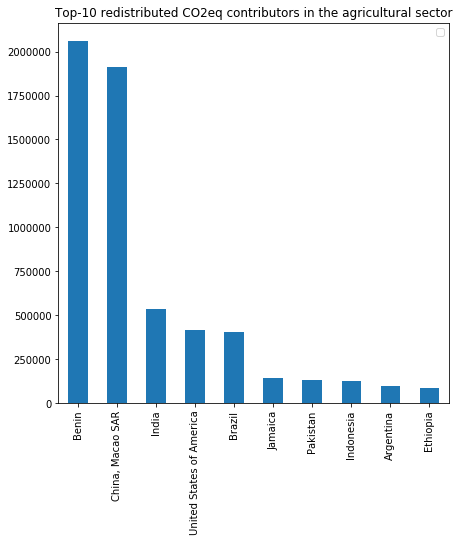

In [78]:
emissions_country_io = emissions_country_total.merge(emissions_export, how='left', left_on='Area', right_on='Exporter')
emissions_country_io = emissions_country_io.merge(emissions_import, how='left', left_on='Area', right_on='Importer')
emissions_country_io.fillna(value=0.0, inplace=True)
emissions_country_io['Normalized Emissions [gigagrams]'] = emissions_country_io['Value'] - \
    emissions_country_io['Out Emissions (CO2eq) [gigagrams]'] + emissions_country_io['In Emissions (CO2eq) [gigagrams]']
emissions_country_io = emissions_country_io.merge(populations_2014, how='inner')
emissions_country_io['Normalized Emissions [Tonnes/capita]'] = emissions_country_io['Normalized Emissions [gigagrams]'] /\
    emissions_country_io['Population']
fig, ax = plt.subplots(figsize=(7, 7))
emissions_country_io.sort_values(by='Normalized Emissions [gigagrams]', ascending=False)\
    .head(10).plot.bar(x='Area', y='Normalized Emissions [gigagrams]', ax=ax)
ax.set_title('')
ax.legend('')
ax.set_xlabel('')
ax.set_title('Top-10 redistributed CO2eq contributors in the agricultural sector')
plt.show()

Add comment

In [79]:
# emissions_normalized = emissions_country_total.merge(populations_df, how='inner')
# emissions_normalized['Normalized Emissions'] = emissions_normalized.Value / (1000 * emissions_normalized.Population)
# emissions_normalized.sort_values(by='Normalized Emissions', ascending=False)

In [80]:
emissions_country = emissions_country[['Area', 'Item', 'Value']].groupby(['Area', 'Item'], as_index=False).agg('mean')
emissions_country = emissions_country.sort_values('Value', ascending=False).groupby(['Area'], as_index=False).first()
emissions_country

,Area,Item,Value
0,Afghanistan,"Milk, whole fresh cow",2904.120664
1,Albania,"Milk, whole fresh cow",1122.009702
2,Algeria,"Meat, sheep",1659.206020
3,American Samoa,"Meat, pig",4.223716
4,Angola,"Meat, cattle",3356.722212
...,...,...,...
219,Western Sahara,"Meat, goat",19.267896
220,Yemen,"Meat, cattle",1163.446271
221,Yugoslav SFR,"Milk, whole fresh cow",9215.473961
222,Zambia,"Meat, cattle",2445.534491


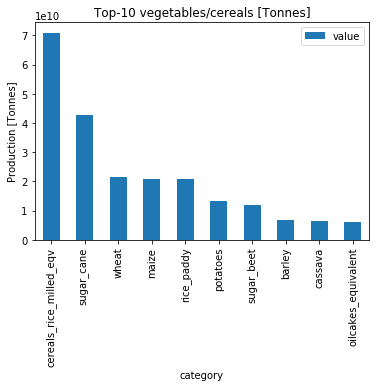

In [81]:
worlds_top_production = fao_crops_df[(fao_crops_df.country_or_area == 'World +') & \
                                     (fao_crops_df.element == 'Production Quantity')][['value', 'category']]
worlds_top_production = worlds_top_production[~worlds_top_production.category.str.contains('total')]
worlds_top_production = worlds_top_production.groupby('category', as_index=False).agg('sum').\
    sort_values(by='value', ascending=False).head(10)
worlds_top_production.plot.bar(x='category', y='value')
plt.title('Top-10 vegetables/cereals [Tonnes]')
plt.ylabel('Production [Tonnes]')
plt.show()

In [82]:
list(filter(lambda x: 'total' in x, fao_crops_df.category.unique()))

['cereals_total',
 'citrus_fruit_total',
 'coarse_grain_total',
 'fruit_excl_melons_total',
 'pulses_total',
 'roots_and_tubers_total',
 'treenuts_total',
 'vegetables_melons_total']

In [83]:
fao_crops_df.year.unique()

array([2007., 2006., 2005., 2004., 2003., 2002., 2001., 2000., 1999.,
       1998., 1997., 1996., 1995., 1994., 1993., 1992., 1991., 1990.,
       1989., 1988., 1987., 1986., 1985., 1984., 1983., 1982., 1981.,
       1980., 1979., 1978., 1977., 1976., 1975., 1974., 1973., 1972.,
       1971., 1970., 1969., 1968., 1967., 1966., 1965., 1964., 1963.,
       1962., 1961.,   nan])

# Title tbd

Now, we proceed like above exept that we aggregate on `Value`. That way, we will be able to plot the total transfer of money (w.r.t. food) bewteen all countries that trade together. 1 unit of `Value` represents 1000 dollars.

In [84]:
# Add geographical grouping for plotting
countries = country_metadata.Country.drop_duplicates().values
continents = country_metadata[(country_metadata['Country Group Code']>5000) & (country_metadata['Country Group Code']%100==0)]
continents = continents['Country Group'].drop_duplicates().values
mapping = country_metadata[country_metadata['Country Group'].isin(continents)].sort_values('Country Code')[['Country Group', 'Country']]

In [85]:
# Exports by total value
exports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Export Value']
exports_2014 = exports_2014[exports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Value']]
exports_2014 = exports_2014.rename(columns={"Reporter Countries": "Exporter", "Partner Countries": "Importer"})
exports_2014 = exports_2014.groupby(['Exporter', 'Importer']).agg('sum').reset_index()

In [86]:
# Imports by total value
imports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Import Value']
imports_2014 = imports_2014[imports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Value']]
imports_2014 = imports_2014.rename(columns={"Reporter Countries": "Importer", "Partner Countries": "Exporter"})
imports_2014 = imports_2014.groupby(['Exporter', 'Importer']).agg('sum').reset_index()

In [87]:
# All total value
merged_exports_2014 = pd.concat([imports_2014, exports_2014])
merged_exports_2014 = merged_exports_2014.groupby(['Exporter', 'Importer']).agg('max').reset_index()
merged_exports_2014 = merged_exports_2014.merge(mapping, left_on='Exporter', right_on='Country', how='inner').rename(columns={'Country Group': "Exporter Continent"}).drop(columns='Country')
merged_exports_2014 = merged_exports_2014.merge(mapping, left_on='Importer', right_on='Country', how='inner').rename(columns={'Country Group': "Importer Continent"}).drop(columns='Country')
merged_exports_2014 = merged_exports_2014.sort_values(['Value'], ascending=[False]).reset_index(drop=True)

# Reduce number of edges for graph
value_graph_edges_2014 = merged_exports_2014.iloc[:100]
value_graph_edges_2014.head(10)

,Exporter,Importer,Value,Exporter Continent,Importer Continent
0,United States of America,Mexico,5613268.0,Americas,Americas
1,United States of America,Japan,4645377.0,Americas,Asia
2,United States of America,Republic of Korea,2302369.0,Americas,Asia
3,Canada,United States of America,2298075.0,Americas,Americas
4,Australia,"China, mainland",2179980.0,Oceania,Asia
5,Netherlands,Germany,1830335.0,Europe,Europe
6,France,Italy,1656814.0,Europe,Europe
7,Germany,Netherlands,1617159.0,Europe,Europe
8,India,Saudi Arabia,1520022.0,Asia,Asia
9,Germany,Italy,1485865.0,Europe,Europe


One of the plots for the data story will be the total transfer of money from trading countries. To avoid overcrowding of the plot, we remove vertices in the plot where the sum of the incoming and outgoing edges have a low value.

In [88]:
# Export to json
most_active_exporter = merged_exports_2014.groupby('Exporter').agg('sum').sort_values('Value', ascending=[False]).iloc[:15].index
most_active_importer = merged_exports_2014.groupby('Importer').agg('sum').sort_values('Value', ascending=[False]).iloc[:15].index
value_graph_edges_2014 = value_graph_edges_2014[value_graph_edges_2014.Exporter.isin(most_active_exporter)]
value_graph_edges_2014 = value_graph_edges_2014[value_graph_edges_2014.Importer.isin(most_active_importer)]
value_graph_edges_2014.to_json('D3/import_export_total_value_2014.json', orient='records')

In [89]:
import networkx as nx

# Make graph
G = nx.from_pandas_edgelist(value_graph_edges_2014, 'Exporter', 'Importer', ['Value'], 
                                  create_using=nx.MultiDiGraph())

# Coloring scale
colors = np.array(value_graph_edges_2014.Value)
colors = colors
colors = (colors - colors.min()) / (colors.max() - colors.min())

/Users/timur/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/timur/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/timur/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/timur/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(n

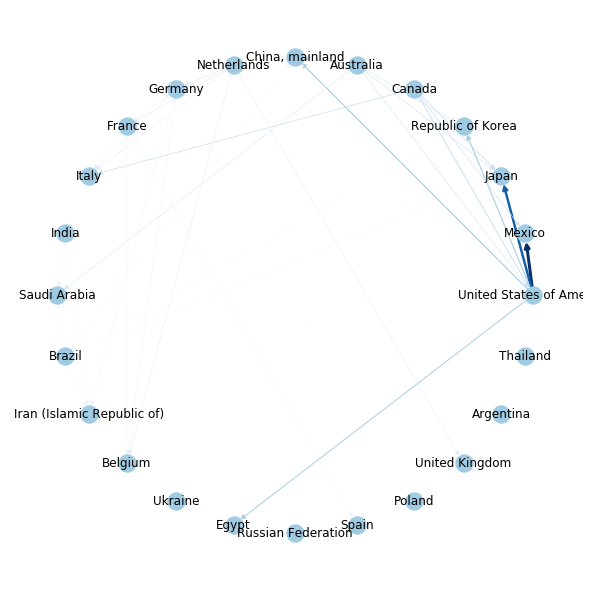

In [90]:
import matplotlib.pyplot as plt

# First attempt at visualisation
plt.figure(figsize=(8, 8))
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color='#A0CBE2', edge_color=colors,
        width=3*colors, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

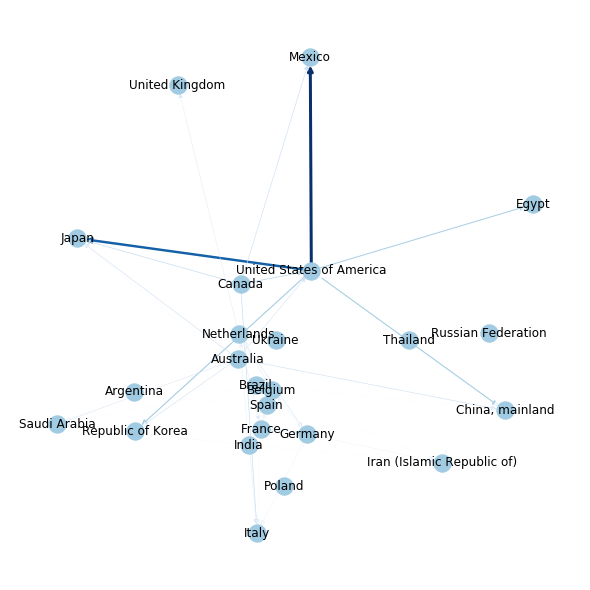

In [91]:
# Different layout
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='#A0CBE2', edge_color=colors,
        width=3*colors, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

The edges in the 2 above plots represent the flow of money (w.r.t. food) between countries. It is beautiful to see that there is a geographical clustering. European countries mostly trade together and the US trades with a lot of other countries (see below for better plot).

One flaw of drawing is that it does not support bidirectional edges since the edges are drawn straight. The plot below solves this. For the data story, we will redo this plots interactive in D3 with curved edges. We will also add a pop-up such that when you hover over a country, you see the top 3 imported / exported item (e.g. cereals, meat, ...)

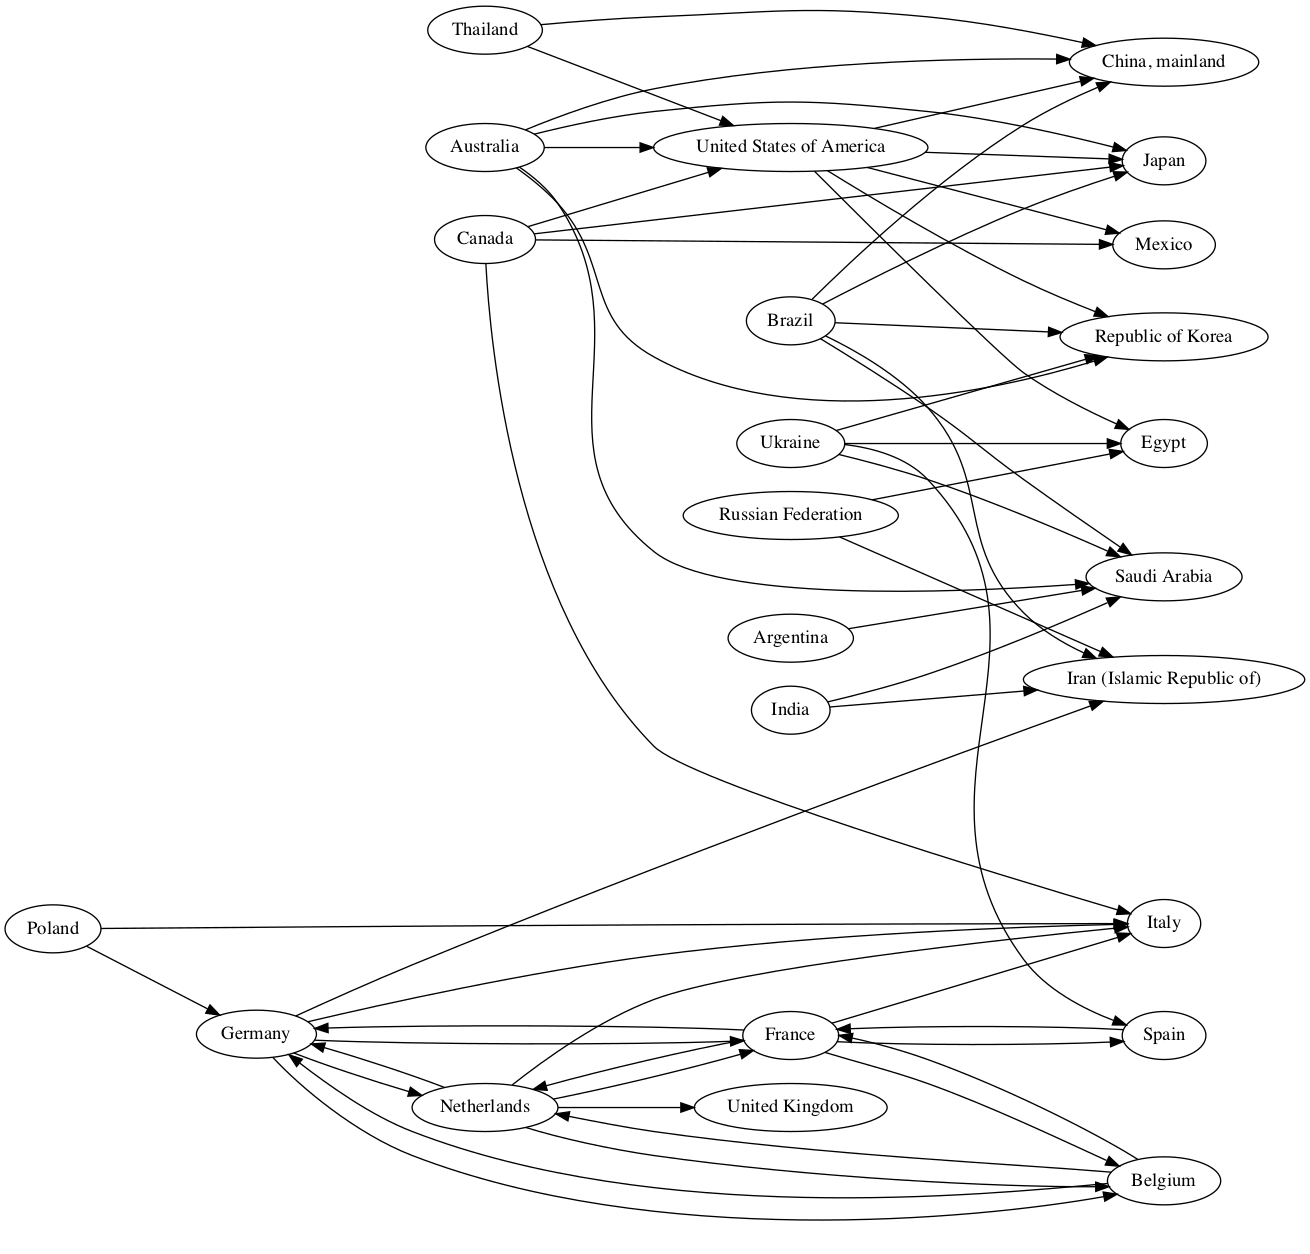

In [92]:
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image

# Other type of graph
G.graph['edge'] = {'arrowsize': '1', 'splines': 'curved'}
A = to_agraph(G)
A.graph_attr.update(ranksep='1', rankdir="LR")
lay = 'dot'
A.layout(lay)
A.draw('figures/export_import_graph.png')
Image(filename='figures/export_import_graph.png')

In [93]:
# Uncomment the below code for graph in SVG format

# from IPython.core.display import SVG
# SVG(filename='figures/export_import_graph.svg')